# Housekeeping

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Gathering Data and Caclulating MFI

In [30]:
TICKER = 'SPY'
MFI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 100000

def get_data(ticker=TICKER):
    df = yf.download(ticker)
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-LOOKBACK:, :]

def add_MFI(df, length=MFI_LENGTH):
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Raw_Money_Flow'] = df['Typical_Price'] * df['Volume']
    df['Price_Change'] = df['Typical_Price'].diff()
    df['Positive_Flow'] = np.where(df['Price_Change'] > 0, df['Raw_Money_Flow'], 0)
    df['Negative_Flow'] = np.where(df['Price_Change'] < 0, df['Raw_Money_Flow'], 0)

    pos_mf = pd.Series(df['Positive_Flow']).rolling(length).sum()
    neg_mf = pd.Series(df['Negative_Flow']).rolling(length).sum()
    money_flow_ratio = pos_mf / neg_mf
    df['MFI'] = 100 - (100 / (1 + money_flow_ratio))

    plt.figure(figsize=(12, 6))
    plt.plot(df['MFI'], label='MFI')
    plt.xlabel('Date')
    plt.axhline(OVERBOUGHT, color='red', linewidth=1, linestyle='--', label = 'Overbought')
    plt.axhline(OVERSOLD, color='green', linewidth=1, linestyle='--', label = 'Oversold')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df

   

# Creating and Testing Strategy

In [31]:

def add_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):
    df['Strategy'] = 0
    df['Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1
    return df

def return_summary(df, ticker=TICKER):
    asset_return = df['Asset_Returns'].iloc[-1] * 100
    strategy_return = df['Strategy_Returns'].iloc[-1] * 100
    print(f"{ticker} Buy & Hold Return: {asset_return:.2f}%")
    print(f"{ticker} MFI Strategy Return: {strategy_return:.2f}%")

def return_summary(df, ticker=TICKER):
    asset_return = df['Asset_Returns'].iloc[-1] * 100
    strategy_return = df['Strategy_Returns'].iloc[-1] * 100
    print(f"{ticker} Buy & Hold Return: {asset_return:.2f}%")
    print(f"{ticker} MFI Strategy Return: {strategy_return:.2f}%")

    plt.figure(figsize=(12, 6))
    plt.plot(df['Asset_Returns'], label=f'{ticker} Buy & Hold', color='red')
    plt.plot(df['Strategy_Returns'], label=f'{ticker} MFI Strategy', color='navy')
    plt.legend()
    plt.title(f'{ticker} MFI Strategy vs Buy & Hold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Executing Code

C:\Users\EWD\AppData\Local\Temp\ipykernel_15404\845595524.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker)
[*********************100%***********************]  1 of 1 completed


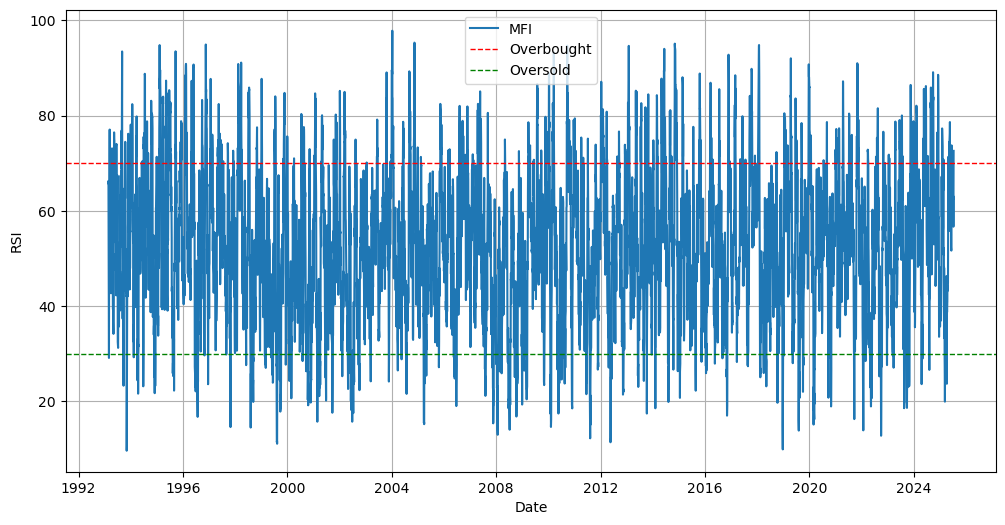

SPY Buy & Hold Return: 2457.87%
SPY MFI Strategy Return: 122.81%


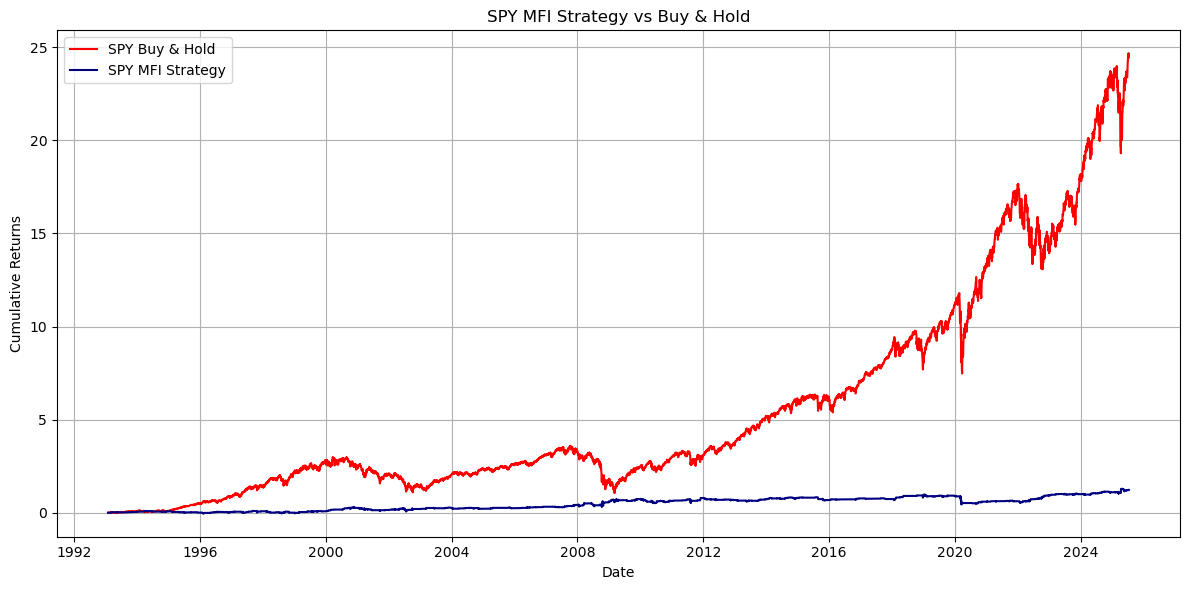

In [32]:
def main():
    df = get_data()
    df = add_MFI(df)
    df = add_strategy(df)
    df = test_strategy(df)
    return_summary(df, TICKER)
    return df

# Run everything
df = main()